In [ ]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, 
from src.graph import NeighborsGraph 
import seaborn as sns 
import matplotlib.pyplot as plt
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')
import json

%load_ext autoreload
%autoreload 2
%matplotlib inline

def save_table(df:pd.DataFrame, path:str=None):
    if path is None:
        return 
    elif path.split('.')[-1] == 'csv':
        df.to_csv(path)
    elif path.split('.')[-1] == 'png':
        dfi.export(df, path)
    return



In [22]:
def recall(df:pd.DataFrame, label:int=0, threshold:float=0.95) -> float:
    '''Computes the precision of the model's predictions. Recall summarizes how well the positive class was predicted and is the same calculation as sensitivity.'''
    model_labels = np.where(df[f'model_output_{label}'] > threshold, label, int(not label))
    n = ((model_labels == label) & (df.label == label)).sum()
    N = (df.label == label).sum() # Total number of relevant instances (i.e. members of the class)
    return n / N

def precision(df:pd.DataFrame, label:int=0, threshold:float=0.95) -> float:
    '''Computes the precision of the model's predictions. Precision summarizes the fraction of examples assigned the positive class that belong to the positive class.'''
    model_labels = np.where(df[f'model_output_{label}'] > threshold, label, int(not label))
    n = ((model_labels == label) & (df.label == label)).sum()
    N = (model_labels == label).sum() # Total number of retrieved instances (i.e. predicted members of the class)
    return n / N

def balanced_accuracy(df:pd.DataFrame):
    '''Compute the balanced accuracy.'''
    return balanced_accuracy_score(df.label, df.model_label)

In [28]:
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')
test_results_df = test_results_df.merge(pd.read_csv('../data/datasets/dataset_test.csv', index_col=0), left_index=True, right_index=True, how='left')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
train_results_df = train_results_df.merge(pd.read_csv('../data/datasets/dataset_train.csv', index_col=0), left_index=True, right_index=True, how='left')

results_df = pd.concat([train_results_df, test_results_df])
results_df['length'] = results_df.seq.apply(len)

In [30]:
def table_1(results_df:pd.DataFrame):

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*pkl')]

    table_df = list()
    for model_name in model_names:
        row = dict()
        row['model_name'] = model_name

        tn, fp, fn, tp = confusion_matrix(results_df['label'], results_df[f'{model_name}_label']).ravel()
        row['true_positive'] = tp
        row['true_negative'] = tn
        row['false_positive'] = fp
        row['false_negative'] = fn
        row['accuracy'] = np.round(balanced_accuracy_score(results_df.label, results_df[f'{model_name}_label']), 4)
        table_df.append(row)

    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false_positive')

    # dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df

table_1(results_df)


,true_positive,true_negative,false_positive,false_negative,accuracy
model_name,,,,,
model_v1,258325,17221,3,1041,0.9979
model_v2,258687,17216,8,679,0.9985
model_v3,258686,17214,10,680,0.9984


In [32]:
model_name = 'model_v2'
train_results_df = train_results_df.rename(columns={col:col.replace(model_name, 'model') for col in train_results_df.columns})
test_results_df = test_results_df.rename(columns={col:col.replace(model_name, 'model') for col in test_results_df.columns})
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})

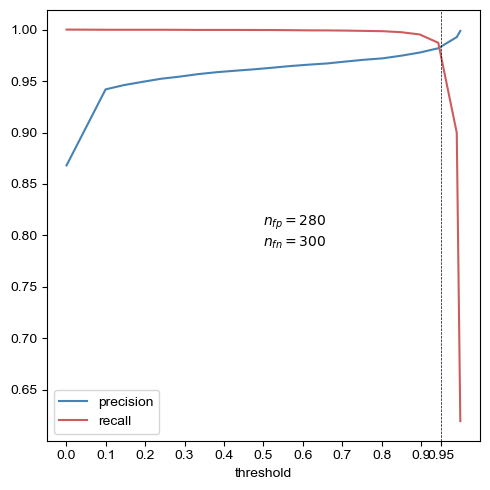

In [47]:
def figure(results_df, threshold:float=0.95, label:int=1):

    min_threshold = results_df[f'model_output_{label}'].min() + 1e-3
    max_threshold = results_df[f'model_output_{label}'].max() - 1e-3

    thresholds = [min_threshold] + list(np.linspace(0.1, 0.99, 20)) + [max_threshold]
    ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
    ax_df['threshold'] = thresholds
    ax_df['precision'] = [precision(results_df, label=label, threshold=threshold) for threshold in thresholds]
    ax_df['recall'] = [recall(results_df, label=label, threshold=threshold) for threshold in thresholds]

    fig, ax = plt.subplots(figsize=(5, 5))

    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='precision', label='precision', color='steelblue')
    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='recall', label='recall', color='indianred')
    ax.axvline(threshold, color='black', linewidth=0.5, linestyle='--')

    results_df['model_label'] = np.where(results_df[f'model_output_{label}'] > threshold, label, int(not label))
    n_fn = ((results_df.model_label == 0) & (results_df.label == 1)).sum()
    n_fp = ((results_df.model_label == 1) & (results_df.label == 0)).sum()
    ax.text(0.5, 0.5, '$n_{fp} = $' + f'${n_fp}$', transform=ax.transAxes)
    ax.text(0.5, 0.45, '$n_{fn} = $' + f'${n_fn}$', transform=ax.transAxes)

    ax.set_ylabel('')
    x_ticks = sorted(list(np.arange(10) / 10) + [threshold])
    ax.set_xticks(x_ticks, labels=x_ticks)

    fig.tight_layout()
    plt.show()

# figure(results_df, threshold=0.7, label=1)
figure(results_df, threshold=0.95, label=0)

In [38]:
threshold = 0.95
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)

fp_results_df = results_df[(results_df.model_label == 1) & (results_df.label == 0)].copy()
fn_results_df = results_df[(results_df.model_label == 0) & (results_df.label == 1)].copy()
tp_results_df = results_df[(results_df.model_label == 1) & (results_df.label == 1)].copy()
tn_results_df = results_df[(results_df.model_label == 0) & (results_df.label == 0)].copy()

print('Number of false positives:', len(fp_results_df), 'out of', (results_df.label == 0).sum())
print('Number of false positives in testing dataset:', (fp_results_df.dataset == 'test').sum(), 'out of', (test_results_df.label == 0).sum())
print('Number of false positives in training dataset:', (fp_results_df.dataset == 'train').sum(), 'out of', (train_results_df.label == 0).sum(), end='\n\n')

print('Number of false negatives:', len(fn_results_df), 'out of', (results_df.label == 1).sum())
print('Number of false negatives in testing dataset:', (fn_results_df.dataset == 'test').sum(), 'out of', (test_results_df.label == 1).sum())
print('Number of false negatives in train dataset:', (fn_results_df.dataset == 'train').sum(), 'out of', (train_results_df.label == 1).sum())


Number of false positives: 280 out of 17224
Number of false positives in testing dataset: 67 out of 3268
Number of false positives in training dataset: 213 out of 13956

Number of false negatives: 300 out of 259366
Number of false negatives in testing dataset: 13 out of 51690
Number of false negatives in train dataset: 287 out of 207676


In [21]:
print('Balanced accuracy on training dataset:', balanced_accuracy(results_df[results_df.dataset == 'train']))
print('Balanced accuracy on testing dataset:', balanced_accuracy(results_df[results_df.dataset == 'test']))

Balanced accuracy on training dataset: 0.9916778934220855
Balanced accuracy on testing dataset: 0.9896233323459007


In [37]:
# Metrics computed with respect to the positive (real) class. 

print('Precision:', precision(results_df, label=1))
print('Precision on training dataset:', precision(results_df[results_df.dataset == 'train'], label=1))
print('Precision on testing dataset:', precision(results_df[results_df.dataset == 'test'], label=1), end='\n\n')

print('Recall:', recall(results_df, label=1))
print('Recall on training dataset:', recall(results_df[results_df.dataset == 'train'], label=1))
print('Recall on testing dataset:', recall(results_df[results_df.dataset == 'test'], label=1))

Precision: 0.9999883779941192
Precision on training dataset: 0.999990317161379
Precision on testing dataset: 0.9999806126405584

Recall: 0.9952268223282928
Recall on training dataset: 0.9945732776055008
Recall on testing dataset: 0.997852582704585


In [36]:
# Metrics computed with respect to the negative (spurious) class. 

print('Precision:', precision(results_df, label=0))
print('Precision on training dataset:', precision(results_df[results_df.dataset == 'train'], label=0))
print('Precision on testing dataset:', precision(results_df[results_df.dataset == 'test'], label=0), end='\n\n')

print('Recall:', recall(results_df, label=0))
print('Recall on training dataset:', recall(results_df[results_df.dataset == 'train'], label=0))
print('Recall on testing dataset:', recall(results_df[results_df.dataset == 'test'], label=0))

Precision: 0.9826026443980515
Precision on training dataset: 0.979543834640057
Precision on testing dataset: 0.9959551960174238

Recall: 0.983743613562471
Recall on training dataset: 0.984737747205503
Recall on testing dataset: 0.9794981640146879


In [55]:
fp_results_df[fp_results_df.model_output_1 > 0.5][['length', 'antifam_id', 'antifam_description']]

,length,antifam_id,antifam_description
id,,,
A0AAQ1SN28,42,ANF00056,Translation of DNA repeat
A0A2X3JQU9,36,ANF00071,Translation of intergenic region
F3P8G0,41,ANF00208,Shadow ORF (opposite rpmJ)
A5KM07,182,ANF00182,Shadow ORF (opposite rplL)
A0A0M3TKS6,38,ANF00053,Translation of DNA repeat
A0A9Q4T167,37,ANF00069,Translation of predicted DNA regulatory sequence
A0A1R3T7N6,59,ANF00014,tRNA translation
A0A0S2IZ81,37,ANF00053,Translation of DNA repeat
